In [1]:
# Trusty machine learning imports
import tensorflow as tf
import numpy as np

In [2]:
# Make sure to run notebook within slim folder
from datasets import dataset_utils
import os

In [3]:
# Base url
TF_MODELS_URL = "http://download.tensorflow.org/models/"

In [4]:
# Modify this path for a different CNN
INCEPTION_V3_URL = TF_MODELS_URL + "inception_v3_2016_08_28.tar.gz"

In [5]:
# Directory to save model checkpoints
MODELS_DIR = "models/cnn"

In [6]:
INCEPTION_V3_CKPT_PATH = MODELS_DIR + "/inception_v3.ckpt"

In [7]:
# Make the model directory if it does not exist
if not tf.gfile.Exists(MODELS_DIR):
 tf.gfile.MakeDirs(MODELS_DIR)

In [8]:
# Download the appropriate model if haven't already done so
if not os.path.exists(INCEPTION_V3_CKPT_PATH): 
 dataset_utils.download_and_uncompress_tarball(INCEPTION_V3_URL, MODELS_DIR)

In [9]:
# Full deep-funneled images dataset
FACES_URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
IMAGES_DOWNLOAD_DIRECTORY = "tmp/faces"
IMAGES_DIRECTORY = "images/faces"

if not os.path.exists(IMAGES_DOWNLOAD_DIRECTORY):
 os.makedirs(IMAGES_DOWNLOAD_DIRECTORY)

In [10]:
# If the file has not already been downloaded, retrieve and extract it
if not os.path.exists(IMAGES_DOWNLOAD_DIRECTORY + "/lfw-deepfunneled.tgz"):
 dataset_utils.download_and_uncompress_tarball(FACES_URL, IMAGES_DOWNLOAD_DIRECTORY)

In [11]:
people_number = []
# Count number of photos of each individual. People number is a list of tuples 
# with each tuple composed of the name and the number of photos of a person.
people = os.listdir(IMAGES_DOWNLOAD_DIRECTORY + '/lfw-deepfunneled/')
people.sort()
for person in people:
 folder_path = IMAGES_DOWNLOAD_DIRECTORY + '/lfw-deepfunneled/' + person
 num_images = len(os.listdir(folder_path))
 people_number.append((person, num_images))

In [12]:
# Sort the list of tuples by the number of images
people_number = sorted(people_number, key=lambda x: x[1], reverse=True)

In [13]:
# List Comprehension to determine number of people with one image
people_with_one_photo = [(person) for person, num_images in people_number if num_images==1]
print("Individuals with one photo: {}".format(len(people_with_one_photo)))

Individuals with one photo: 4069


In [14]:
from distutils.dir_util import copy_tree
# Number of individuals to retain
num_classes = 10

In [15]:
# Make the images directory if it does not exist
if not os.path.exists(IMAGES_DIRECTORY):
 os.makedirs(IMAGES_DIRECTORY)

In [16]:
# Take the ten folders with the most images and move to new directory
# Rename the folders with the number of images and name of individual
for person in people_number[:num_classes]:
    name = person[0]
    # Original download directory path
    folder_path = IMAGES_DOWNLOAD_DIRECTORY + '/lfw-deepfunneled/' + name
    formatted_num_images = str(person[1]).zfill(3)
    new_folder_name = "{} {}".format(formatted_num_images, name)
    image_new_name = IMAGES_DIRECTORY + "/" + new_folder_name
    if not any(name in d for d in os.listdir(IMAGES_DIRECTORY)):
        # Make a new folder for each individual in the images directory
        os.mkdir(IMAGES_DIRECTORY + '/' + name)
        # Copy the folder from the download location to the new folder
        copy_tree(folder_path, IMAGES_DIRECTORY + '/' + name)
        # Rename the folder with images and individual
        os.rename(IMAGES_DIRECTORY + '/' + name, image_new_name)

In [17]:
print(os.listdir("images/faces"))
# Map each class to an integer label
class_mapping = {}
class_images = {}
# Create dictionary to map integer labels to individuals
# Class_images will record number of images for each class
for index, directory in enumerate(os.listdir("images/faces")):
 class_mapping[index] = directory.split(" ")[1]
 class_images[index] = int(directory.split(' ')[0])
print(class_mapping)

['236 Colin_Powell', '077 Ariel_Sharon', '144 Tony_Blair', '071 Hugo_Chavez', '109 Gerhard_Schroeder', '530 George_W_Bush', '060 Junichiro_Koizumi', '121 Donald_Rumsfeld', '055 Jean_Chretien', '053 John_Ashcroft']
{0: 'Colin_Powell', 1: 'Ariel_Sharon', 2: 'Tony_Blair', 3: 'Hugo_Chavez', 4: 'Gerhard_Schroeder', 5: 'George_W_Bush', 6: 'Junichiro_Koizumi', 7: 'Donald_Rumsfeld', 8: 'Jean_Chretien', 9: 'John_Ashcroft'}


In [18]:
total_num_images = np.sum(list(class_images.values()))
print("Individual \t Composition of Dataset\n")
for label, num_images in class_images.items():
 print("{:20} {:.2f}%".format(
 class_mapping[label], (num_images / total_num_images) * 100))

Individual 	 Composition of Dataset

Colin_Powell         16.21%
Ariel_Sharon         5.29%
Tony_Blair           9.89%
Hugo_Chavez          4.88%
Gerhard_Schroeder    7.49%
George_W_Bush        36.40%
Junichiro_Koizumi    4.12%
Donald_Rumsfeld      8.31%
Jean_Chretien        3.78%
John_Ashcroft        3.64%


In [19]:
import matplotlib.pyplot as plt
image_arrays = []
image_labels = []
root_image_directory = "images/faces/"
for label, person in class_mapping.items():
    for directory in os.listdir(root_image_directory):
        if directory.split(" ")[1] == person:
            image_directory = root_image_directory + directory
            break
    for image in os.listdir(image_directory):
        image = plt.imread(os.path.join(image_directory, image))
        image_arrays.append(image)
        image_labels.append(label)
image_arrays = np.array(image_arrays)
image_labels = np.array(image_labels)
print(image_arrays.shape, image_labels.shape)

(1456, 250, 250, 3) (1456,)


In [20]:
import math
from collections import Counter
# Fractions for each dataset
train_frac = 0.70
valid_frac = 0.05
test_frac = 0.25

In [21]:
# This function takes in np arrays of images and labels along with split fractions
# and returns the six data arrays corresponding to each dataset as the appropriate type
def create_data_splits(X, y, train_frac=train_frac, test_frac=test_frac, valid_frac=valid_frac):
    X = np.array(X)
    y = np.array(y)
    # Make sure that the fractions sum to 1.0
    assert (test_frac + valid_frac + train_frac == 1.0), "Test + Valid + Train Fractions must sum to 1.0"
    X_raw_test = []
    X_raw_valid = []
    X_raw_train = []

    y_raw_test = []
    y_raw_valid = []
    y_raw_train = []

    # Randomly order the data and labels
    random_indices = np.random.permutation(len(X))
    X = X[random_indices]
    y = y[random_indices]
    
    for image, label in zip(X, y):
 
        # Number of images that correspond to desired fraction
        test_length = math.floor(test_frac * class_images[label])
        valid_length = math.floor(valid_frac * class_images[label])

        # Check to see if the datasets have the right number of labels (and images)
        if Counter(y_raw_test)[label] < test_length:
            X_raw_test.append(image)
            y_raw_test.append(label)
        elif Counter(y_raw_valid)[label] < valid_length:
            X_raw_valid.append(image)
            y_raw_valid.append(label)
        else:
            X_raw_train.append(image)
            y_raw_train.append(label)

    return np.array(X_raw_train, dtype=np.float32), np.array(X_raw_valid, dtype=np.float32), np.array(X_raw_test, dtype=np.float32), np.array(y_raw_train, dtype=np.int32), np.array(y_raw_valid, dtype=np.int32), np.array(y_raw_test, dtype=np.int32)

In [22]:
# Create all the testing splits using the create_splits function
X_train, X_valid, X_test, y_train, y_valid, y_test = create_data_splits(image_arrays, image_labels)

In [23]:
# Check the number of images in each dataset split
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(1027, 250, 250, 3) (68, 250, 250, 3) (361, 250, 250, 3)
(1027,) (68,) (361,)


In [24]:
# Import matplotlib and use magic command to plot in notebook
import matplotlib.pyplot as plt
%matplotlib inline
# Function to plot an array of RGB values 
def plot_color_image(image):
    plt.figure(figsize=(4,4))
    plt.imshow(image.astype(np.uint8), interpolation='nearest')
    plt.axis('off')

Colin_Powell Number of Images: 236


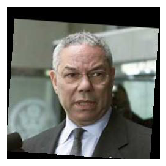

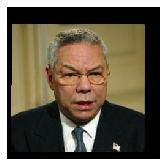

Ariel_Sharon Number of Images: 77


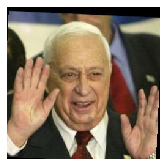

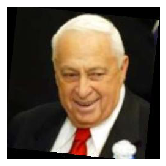

Tony_Blair Number of Images: 144


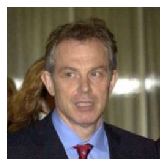

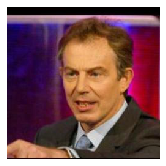

Hugo_Chavez Number of Images: 71


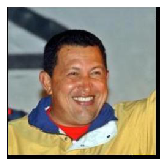

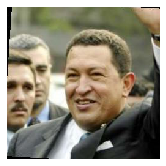

Gerhard_Schroeder Number of Images: 109


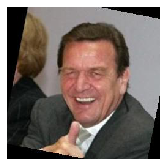

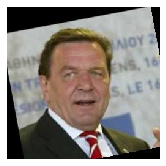

George_W_Bush Number of Images: 530


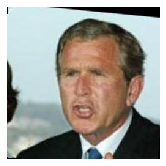

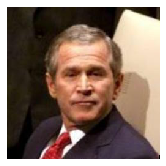

Junichiro_Koizumi Number of Images: 60


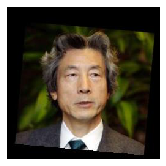

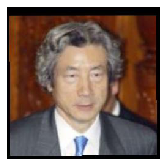

Donald_Rumsfeld Number of Images: 121


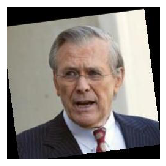

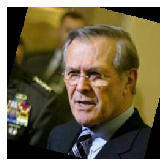

Jean_Chretien Number of Images: 55


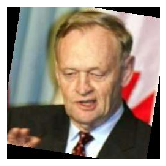

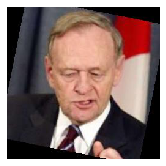

John_Ashcroft Number of Images: 53


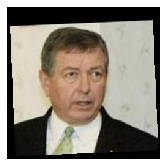

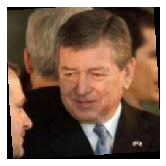

In [25]:
import random
# PLot 2 examples from each class
num_examples = 2
# Iterate through the classes and plot 2 images from each
for class_number, person in class_mapping.items():
    print('{} Number of Images: {}'.format(person, class_images[class_number]))
    example_images = []
    while len(example_images) < num_examples:
        random_index = np.random.randint(len(X_train))
        if y_train[random_index] == class_number:
            example_images.append(X_train[random_index])
 
    for i, image in enumerate(example_images):
        plt.subplot(100 + num_examples*10 + i + 1)
        plt.imshow(image.astype(np.uint8), interpolation='nearest')
        plt.axis('off')
        plt.show()

In [26]:
#from scipy.misc import imresize
from PIL import Image
# Function takes in an image array and returns the resized and normalized array
def prepare_image(image, target_height=299, target_width=299):
    # im = imresize(im, (h, int(w * aspect_ratio)), interp='bicubic')
    # im = np.array(Image.fromarray(im).resize((h, int(w * aspect_ratio))))
    #image = imresize(image, (target_width, target_height))
    image = np.array(Image.fromarray(image.astype('uint8')).resize((target_width, target_height)))
    return image.astype(np.float32) / 255

In [27]:
from nets import inception 
from tensorflow.contrib import slim
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 299, 299, 3], name='X')
is_training = tf.placeholder_with_default(False, [])
# Run inception function to determine endpoints
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=is_training)
# Create saver of network before alterations
inception_saver = tf.train.Saver()
print(end_points)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





{'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>, 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>, 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>, 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>, 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>, 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>, 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=float32>, 'Mixed_5b': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5b/concat:0' shape=(?, 35, 35, 256) dtype=float32>, 'Mixed_5c': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5c/concat:0' shape=(?, 35, 35,

In [28]:
# Isolate the trainable layer
prelogits = tf.squeeze(end_points['PreLogits'], axis=[1,2])
# Define the training layer and the new output layer
n_outputs = len(class_mapping)
with tf.name_scope("new_output_layer"):
    people_logits = tf.layers.dense(prelogits, n_outputs, name="people_logits")
    probability = tf.nn.softmax(people_logits, name='probability')
# Placeholder for labels
y = tf.placeholder(tf.int32, None)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
# Loss function and training operation
# The training operation is passed the variables to train which includes only the single layer
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=people_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    # Single layer to be trained
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="people_logits")
    # The variables to train are passed to the training operation
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [30]:
# Accuracy for network evaluation
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(predictions=people_logits, targets=y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
 
# Intialization function and saver
with tf.name_scope("init_and_saver"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [31]:
# Function takes in an array of images and labels and processes the images to create
# a batch of a given size
def create_batch(X, y, start_index=0, batch_size=4):
 
    stop_index = start_index + batch_size
    prepared_images = []
    labels = []

    for index in range(start_index, stop_index):
        prepared_images.append(prepare_image(X[index]))
        labels.append(y[index])

    # Combine the images into a single array by joining along the 0th axis
    X_batch = np.stack(prepared_images)
    # Combine the labels into a single array
    y_batch = np.array(labels, dtype=np.int32)

    return X_batch, y_batch

In [32]:
X_valid, y_valid = create_batch(X_valid, y_valid, 0, len(X_valid))
print(X_valid.shape, y_valid.shape)

(68, 299, 299, 3) (68,)


In [33]:
with tf.name_scope("tensorboard_writing"):
    # Track validation accuracy and loss and training accuracy
    valid_acc_summary = tf.summary.scalar(name='valid_acc', tensor=accuracy)
    valid_loss_summary = tf.summary.scalar(name='valid_loss', tensor=loss)
    train_acc_summary = tf.summary.scalar(name='train_acc', tensor=accuracy)
    # Merge the validation stats
    valid_merged_summary = tf.summary.merge(inputs=[valid_acc_summary, valid_loss_summary])
# Use the time to differentiate the different training sessions
from datetime import datetime
import time
# Specify the directory for the FileWriter
now = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = "{}_unaugmented".format(now)
logdir = "tensorboard/faces/" + model_dir
file_writer = tf.summary.FileWriter(logdir=logdir, graph=tf.get_default_graph())

In [34]:
n_epochs = 100
batch_size = 32
# Early stopping parameters
max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.float("inf")
# Show progress every show_progress epochs
show_progress = 1
# Want to iterate through the entire training set every epoch
n_iterations_per_epoch = len(X_train) // batch_size
# Specify the directory for the FileWriter
now = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = "{}_unaugmented".format(now)
logdir = "tensorboard/faces/" + model_dir
file_writer = tf.summary.FileWriter(logdir=logdir, graph=tf.get_default_graph())

In [35]:
# This is the pre-trained model checkpoint training path
inception_v3_checkpoint_path = "models/cnn/inception_v3.ckpt"
# This is the checkpoint path for our trained model with no dataaugmentation
unaugmented_training_path = "models/cnn/inception_v3_faces_unaugmented.ckpt"

In [36]:
with tf.Session() as sess:
    init.run()
    # Restore all the weights from the original CNN
    inception_saver.restore(sess, inception_v3_checkpoint_path)
    print('1')

    t0 = time.time()
    for epoch in range(n_epochs):
        print('2')
        start_index = 0
        # Each epoch, iterate through all the training instances
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = create_batch(X_train, y_train, start_index, batch_size)
            # Train the trainable layer 
            sess.run(training_op, {X: X_batch, y: y_batch})
            start_index += batch_size

        print('3')
        # Display the progress of training and write to the TensorBoard directory
        # for later visualization of the training
        if epoch % show_progress == 0:
                print('4')
                train_summary = sess.run(train_acc_summary, {X: X_batch, y: y_batch})
                file_writer.add_summary(train_summary, (epoch+1))
                #Size for validation limited by GPU memory (68 images will work)
                valid_loss, valid_acc, valid_summary = sess.run([loss, accuracy, valid_merged_summary], {X: X_valid, y: y_valid})
                file_writer.add_summary(valid_summary, (epoch+1))
                print('Epoch: {:4} Validation Loss: {:.4f} Accuracy: {:4f}'.format(epoch+1, valid_loss, valid_acc))
 
        # Check to see if network is still improving, if improved during epoch
        # a snapshot of the model will be saved to retain the best model
        if valid_loss < best_loss:
            print('5')
            best_loss = valid_loss
            checks_without_progess = 0
            save_path = saver.save(sess, unaugmented_training_path)
        # If network is not improving for a specified number of epochs, stop training
        else:
            print('6')
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print('Stopping Early! Loss has not improved in {} epochs'.format(max_checks_without_progress))
                break
 
    t1 = time.time()
 
print('Total Training Time: {:.2f} minutes'.format( (t1-t0) / 60))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/cnn/inception_v3.ckpt
1
2
3
4
Epoch:    1 Validation Loss: 2.2231 Accuracy: 0.470588
5
2
3
4
Epoch:    2 Validation Loss: 1.6514 Accuracy: 0.514706
5
Total Training Time: 5.71 minutes


In [37]:
eval_batch_size = 32
n_iterations = len(X_test) // eval_batch_size
with tf.Session() as sess:
    # Restore the new trained model 
    saver.restore(sess, unaugmented_training_path)

    start_index = 0
    # Create a dictionary to store all the accuracies
    test_acc = {}

    t0 = time.time()
    # Iterate through entire testing set one batch at a time
    print(n_iterations)
    for iteration in range(n_iterations):
        X_test_batch, y_test_batch = create_batch(X_test, y_test, start_index, batch_size=eval_batch_size)
        test_acc[iteration] = accuracy.eval({X: X_test_batch, y:y_test_batch})
        start_index += eval_batch_size
        print('Iteration: {} Batch Testing Accuracy: {:.2f}%'.format(iteration+1, test_acc[iteration] * 100))
 
    t1 = time.time()
    # Final accuracy is mean of each batch accuracy
    print('\nFinal Testing Accuracy: {:.4f}% on {} instances.'.format(
    np.mean(list(test_acc.values())) * 100, len(X_test)))
    print('Total evaluation time: {:.4f} seconds'.format((t1-t0)))

INFO:tensorflow:Restoring parameters from models/cnn/inception_v3_faces_unaugmented.ckpt
11
Iteration: 1 Batch Testing Accuracy: 59.38%
Iteration: 2 Batch Testing Accuracy: 50.00%
Iteration: 3 Batch Testing Accuracy: 25.00%
Iteration: 4 Batch Testing Accuracy: 53.12%
Iteration: 5 Batch Testing Accuracy: 34.38%
Iteration: 6 Batch Testing Accuracy: 56.25%
Iteration: 7 Batch Testing Accuracy: 43.75%
Iteration: 8 Batch Testing Accuracy: 50.00%
Iteration: 9 Batch Testing Accuracy: 56.25%
Iteration: 10 Batch Testing Accuracy: 59.38%
Iteration: 11 Batch Testing Accuracy: 68.75%

Final Testing Accuracy: 50.5682% on 361 instances.
Total evaluation time: 48.6546 seconds


In [38]:
import scipy
# Take in an image as an array and return image with a [dx, dy] shift
def shift_image(image_array, shift):
 return scipy.ndimage.interpolation.shift(image_array, shift, cval=0)

In [39]:
# Four shifts of 30 pixels 
shifts = [[30,0], [-30,0], [0, 30], [0,-30]]
shifted_images = []
shifted_labels = []
# Iterate through all training images
for image, label in zip(X_train, y_train):
    # Swap the color channel and height axis 
    layers = np.swapaxes(image, 0, 2)

    # Apply four shifts to each original image
    for shift in shifts:
        transposed_image_layers = []

        # Apply the shift to the image one layer at a time
        # Each layer is an RGB color channel
        for layer in layers:
            transposed_image_layers.append(shift_image(layer, shift))

        # Stack the RGB layers to get one image and reswap the axes
        transposed_image = np.stack(transposed_image_layers)
        transposed_image = np.swapaxes(transposed_image, 0, 2)

        # Add the shifted images and the labels to a list
        shifted_images.append(transposed_image)
        shifted_labels.append(label)

SyntaxError: invalid syntax (<ipython-input-39-fe5581a36930>, line 9)

In [81]:
# Convert the images and labels to numpy arrays
shifted_images = np.array(shifted_images)
shifted_labels = np.array(shifted_labels)
print(shifted_images.shape,shifted_labels.shape)

(4108, 250, 250, 3) (4108,)


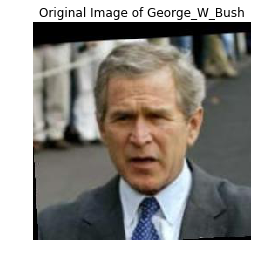

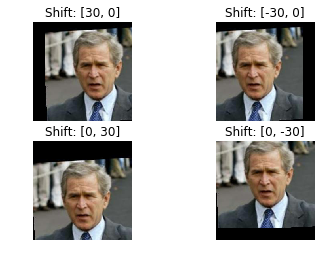

In [82]:
ex_index = 5
# Plot original image
plot_color_image(X_train[ex_index])
plt.title("Original Image of {}".format(class_mapping[y_train[ex_index]]))
plt.show()
ex_shifted_images = shifted_images[ex_index*4:(ex_index*4)+ 4]
# Plot four shifted images
for i, image in enumerate(ex_shifted_images):
    shift = shifts[i]
    plt.subplot(2,2,i+1)
    plt.imshow(image.astype(np.uint8), interpolation='nearest')
    plt.title('Shift: {}'.format(shift))
    plt.axis('off')
plt.show()

In [83]:
# Create a new training set with the original and shifted images
X_train_exp = np.concatenate((shifted_images, X_train))
y_train_exp = np.concatenate((shifted_labels, y_train))
print(X_train_exp.shape, y_train_exp.shape)

(5135, 250, 250, 3) (5135,)


In [84]:
# Randomize the order of the shifted images
random_indices = np.random.permutation(len(X_train_exp))
X_train_exp = X_train_exp[random_indices]
y_train_exp = y_train_exp[random_indices]

In [85]:
print(X_train_exp.shape, y_train_exp.shape)

(5135, 250, 250, 3) (5135,)


In [88]:
n_epochs = 100
batch_size = 32
max_checks_without_progress = 20
checks_without_progress = 0
check_progress = 1
best_loss = np.float("inf")
n_iterations_per_epoch = len(X_train_exp) // batch_size
now = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = "{}_augmented".format(now)
logdir = "tensorboard/faces/" + model_dir
file_writer = tf.summary.FileWriter(logdir=logdir, graph=tf.get_default_graph())
inception_v3_checkpoint_path = "models/cnn/inception_v3.ckpt"
augmented_training_path = "models/cnn/inception_v3_faces_augmented.ckpt"
with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, inception_v3_checkpoint_path)
    t0 = time.time()
    for epoch in range(n_epochs):
        start_index = 0
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = create_batch(X_train_exp, y_train_exp, start_index, batch_size)
            sess.run(training_op, {X: X_batch, y: y_batch})
            start_index += batch_size
        if epoch % show_progress == 0:
            train_summary = sess.run(train_acc_summary, {X: X_batch, y: y_batch})
            file_writer.add_summary(train_summary, (epoch+1))
            #Size for validation limited by GPU memory (68 images will work)
            valid_loss, valid_acc, valid_summary = sess.run([loss, accuracy, valid_merged_summary], {X: X_valid, y: y_valid})
            file_writer.add_summary(valid_summary, (epoch+1))
            print('Epoch: {} Validation Loss: {:.4f} Accuracy: {:4f}'.format(epoch+1, valid_loss, valid_acc))
        if valid_loss < best_loss:
            best_loss = valid_loss
            checks_without_progess = 0
            save_path = saver.save(sess, augmented_training_path)
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print('Stopping Early! Loss has not improved in {} epochs'.format(max_checks_without_progress))
                break
    t1 = time.time()
print('Total Training Time: {:.2f} minutes'.format( (t1-t0) / 60))

INFO:tensorflow:Restoring parameters from models/cnn/inception_v3.ckpt


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


Epoch: 1 Validation Loss: 1.5211 Accuracy: 0.632353
Epoch: 2 Validation Loss: 1.2686 Accuracy: 0.661765
Epoch: 3 Validation Loss: 1.3325 Accuracy: 0.617647
Epoch: 4 Validation Loss: 1.3871 Accuracy: 0.617647
Epoch: 5 Validation Loss: 1.1835 Accuracy: 0.705882
Epoch: 6 Validation Loss: 1.1164 Accuracy: 0.705882
Epoch: 7 Validation Loss: 1.2141 Accuracy: 0.705882
Epoch: 8 Validation Loss: 1.3326 Accuracy: 0.720588
Epoch: 9 Validation Loss: 1.2236 Accuracy: 0.735294
Epoch: 10 Validation Loss: 1.2534 Accuracy: 0.720588
Epoch: 11 Validation Loss: 1.6923 Accuracy: 0.617647
Epoch: 12 Validation Loss: 1.5355 Accuracy: 0.735294
Epoch: 13 Validation Loss: 1.5158 Accuracy: 0.764706
Epoch: 14 Validation Loss: 1.4657 Accuracy: 0.735294
Epoch: 15 Validation Loss: 1.4313 Accuracy: 0.676471
Epoch: 16 Validation Loss: 1.4686 Accuracy: 0.779412
Epoch: 17 Validation Loss: 1.6235 Accuracy: 0.676471
Epoch: 18 Validation Loss: 1.8994 Accuracy: 0.750000
Epoch: 19 Validation Loss: 2.5623 Accuracy: 0.676471
Ep

In [2]:
with tf.Session() as sess:
    saver.restore(sess, augmented_training_path)

    start_index = 0
    test_acc = {}
    t0 = time.time()

    for iteration in range(n_iterations):
        X_test_batch, y_test_batch = create_batch(X_test, y_test, start_index=start_index, batch_size=eval_batch_size)
        test_acc[iteration] = accuracy.eval({X: X_test_batch, y:y_test_batch})
        start_index += eval_batch_size

        print('Iteration: {} Batch Testing Accuracy: {:.2f}%'.format(
            iteration+1, test_acc[iteration] * 100))
    t1 = time.time()

    print('\\nFinal Augmented with Clean Start Testing Accuracy: {:.4f}% on {} instances.'.format(np.mean(list(test_acc.values())) * 100, len(X_test)))

    print('Evaluation Time: {:.2f} seconds'.format( (t1 - t0)))

NameError: name 'tf' is not defined

In [4]:
def classify_image(index, images=X_test, labels=y_test):
    image_array = images[index]
    label = class_mapping[labels[index]]

    prepared_image = prepare_image(image_array)
    prepared_image = np.reshape(prepared_image, newshape=(-1, 299, 299, 3))

    with tf.Session() as sess:
        saver.restore(sess, augmented_training_path)
        predictions = sess.run(probability, {X: prepared_image})

    predictions = [(i, prediction) for i, prediction in enumerate(predictions[0])]
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    print('\nCorrect Answer: {}'.format(label)) 
    print('\nPredictions:')
    for prediction in predictions:
        class_label = prediction[0]
        probability_value = prediction[1]
        label = class_mapping[class_label]
        print("{:26}: {:.2f}%".format(label, probability_value * 100))

    plot_color_image(image_array)
    return predictions

NameError: name 'X_test' is not defined

In [1]:
classify_image(23)

NameError: name 'classify_image' is not defined